# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from dataset_helpers import Generic_Dataset
import matplotlib.pyplot as plt

/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = (torch.tensor(loglik_copula) + log_marginals).to(device)


/tmp/ipykernel_1694143/3463905256.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/tmp/ipykernel_1694143/3463905256.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/tmp/ipykernel_1694143/3463905256.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_da

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = (torch.tensor(loglik_copula) + log_marginals).to(device)


loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = (torch.tensor(loglik_copula) + log_marginals).to(device)

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = (torch.tensor(loglik_copula) + log_marginals).to(device)

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [5]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [6]:

model_freq = GTM(
    number_variables = 2,
    number_transformation_layers = 1,
    number_decorrelation_layers = 3,
    degree_transformations = 10,
    degree_decorrelation = 40,
    spline_transformation = "bspline",
    spline_decorrelation = "bspline",
    transformation_spline_range = (-10, 10),
    device = device) 

study = model_freq.hyperparameter_tune_penalties( 
        train_dataloader = dataloader_train,
        validate_dataloader = dataloader_validate,
        penalty_decorrelation_ridge_param = None,
        penalty_decorrelation_ridge_first_difference = "sample",
        penalty_decorrelation_ridge_second_difference = "sample",
        penalty_transformation_ridge_second_difference = None,
        penalty_lasso_conditional_independence = None,
        adaptive_lasso_weights_matrix=False,
        optimizer="LBFGS",
        learning_rate=1,
        iterations=2000,
        patience=5,
        min_delta=1e-7,
        seperate_copula_training=False,
        max_batches_per_iter=False,
        pretrained_transformation_layer=True,
        n_trials=30,
        temp_folder=".",
        study_name=None)
        

penalty_splines_params=torch.FloatTensor([
                            0, #study.best_params["penalty_decorrelation_ridge_param"],
                            study.best_params["penalty_decorrelation_ridge_first_difference"],
                            study.best_params["penalty_decorrelation_ridge_second_difference"],
                            0 #study.best_params["penalty_transformation_ridge_second_difference"]
                              ])
adaptive_lasso_weights_matrix = False
penalty_lasso_conditional_independence=False




/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/optuna/samplers/_tpe/sampler.py:319: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-11-06 15:56:59,282] A new study created in RDB with name: no-name-e18cb5d7-b47f-4595-9a33-4ec3f352775e
  0%|          | 0/2000 [00:00<?, ?it/s]/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  x=input_a_clone.T, t=knots.T, c=params_a.T, p=order, d=derivativ
  0%|          | 1/2000 [00:00<10:49,  3.08it/s]

current_loss: tensor(1.4585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.4331104755401611
current_loss: tensor(1.4545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.414452314376831
current_loss: tensor(1.4386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4530, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:42, 12.29it/s]

current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3967922925949097
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3943427801132202
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3941514492034912
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3941658735275269
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:09, 15.41it/s]

current_loss_val:  1.3941497802734375
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3939456939697266
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3936456441879272
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3937262296676636
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:00<02:32, 13.02it/s]


current_loss_val:  1.3937181234359741
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3936619758605957
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3938404321670532
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3939355611801147
Early Stop at iteration 13 with minimal loss tensor(1.3936, device='cuda:0') and patience 5 and min_delta 1e-07


  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.4244, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<03:23,  9.84it/s]

current_loss: tensor(1.3893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3561996221542358
current_loss: tensor(1.3893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3040742874145508
current_loss: tensor(1.3434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3451, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:22,  9.84it/s]

current_loss: tensor(1.3258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2903189659118652
current_loss: tensor(1.3258, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2864290475845337
current_loss: tensor(1.3152, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3100, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:06, 10.67it/s]

current_loss_val:  1.2843049764633179
current_loss: tensor(1.3100, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.282188892364502
current_loss: tensor(1.3063, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3034, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:00, 11.07it/s]

current_loss_val:  1.279571294784546
current_loss: tensor(1.3034, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:56, 11.30it/s]

current_loss: tensor(1.3008, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2777347564697266
current_loss: tensor(1.3008, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2751694917678833
current_loss: tensor(1.2980, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2943, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:53, 11.44it/s]

current_loss_val:  1.2684935331344604
current_loss: tensor(1.2943, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2668461799621582
current_loss: tensor(1.2893, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2874, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2657041549682617
current_loss: tensor(1.2874, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:54, 11.41it/s]

current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.261579155921936
current_loss: tensor(1.2818, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258637547492981
current_loss: tensor(1.2810, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:53, 11.47it/s]

current_loss_val:  1.2583972215652466
current_loss: tensor(1.2780, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.258114218711853
current_loss: tensor(1.2773, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:51, 11.55it/s]

current_loss_val:  1.2575925588607788
current_loss: tensor(1.2766, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:51, 11.58it/s]

current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2559453248977661
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2549997568130493
current_loss: tensor(1.2742, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:50, 11.60it/s]

current_loss_val:  1.254525899887085
current_loss: tensor(1.2734, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2535068988800049
current_loss: tensor(1.2721, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2724, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:01, 10.90it/s]

current_loss_val:  1.2533427476882935
current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532389163970947
current_loss: tensor(1.2715, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2529070377349854
current_loss: tensor(1.2709, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<04:24,  7.47it/s]

current_loss_val:  1.2525291442871094
current_loss: tensor(1.2704, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<05:05,  6.47it/s]

current_loss_val:  1.2519534826278687
current_loss: tensor(1.2698, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:03<05:48,  5.67it/s]

current_loss_val:  1.251420497894287
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<06:14,  5.27it/s]

current_loss_val:  1.2504332065582275
current_loss: tensor(1.2682, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:03<07:59,  4.11it/s]

current_loss_val:  1.2488442659378052
current_loss: tensor(1.2672, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:04<09:05,  3.61it/s]

current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.248057246208191
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:04<09:23,  3.50it/s]

current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247360110282898


  2%|▏         | 32/2000 [00:04<11:03,  2.96it/s]

current_loss: tensor(1.2653, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2457876205444336
current_loss: tensor(1.2642, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:05<10:55,  3.00it/s]

current_loss_val:  1.2441447973251343
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:05<11:04,  2.96it/s]

current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441089153289795
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:05<11:34,  2.83it/s]

current_loss_val:  1.2440794706344604
current_loss: tensor(1.2621, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:06<11:29,  2.85it/s]

current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440298795700073


  2%|▏         | 37/2000 [00:06<11:26,  2.86it/s]

current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439454793930054
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438232898712158


  2%|▏         | 38/2000 [00:06<10:57,  2.98it/s]

current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:07<11:19,  2.89it/s]

current_loss_val:  1.2437939643859863
current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:07<11:07,  2.94it/s]

current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243736743927002


  2%|▏         | 41/2000 [00:07<10:08,  3.22it/s]

current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436401844024658


  2%|▏         | 42/2000 [00:08<08:56,  3.65it/s]

current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435412406921387
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:08<08:06,  4.02it/s]

current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435767650604248
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:08<07:05,  4.60it/s]

current_loss_val:  1.2435959577560425
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436504364013672
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:08<08:17,  3.93it/s]

current_loss_val:  1.2437520027160645
current_loss: tensor(1.2584, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:09<06:31,  5.00it/s]

current_loss_val:  1.2437946796417236
Early Stop at iteration 46 with minimal loss tensor(1.2435, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:57:12,442] Trial 0 finished with value: -2.4870822429656982 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.931782391934643, 'penalty_decorrelation_ridge_second_difference': 24.051697888839428}. Best is trial 0 with value: -2.4870822429656982.
  0%|          | 1/2000 [00:00<05:25,  6.14it/s]

current_loss: tensor(1.2785, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439173460006714


  0%|          | 2/2000 [00:00<05:53,  5.65it/s]

current_loss: tensor(1.2779, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244025468826294
current_loss: tensor(1.2770, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<06:01,  5.53it/s]

current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2443767786026
current_loss: tensor(1.2758, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<06:05,  5.46it/s]

current_loss_val:  1.24490225315094
current_loss: tensor(1.2748, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2781, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<07:44,  4.29it/s]

current_loss_val:  1.2464429140090942
current_loss: tensor(1.2730, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2722, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247354507446289
Early Stop at iteration 5 with minimal loss tensor(1.2439, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:57:14,255] Trial 1 finished with value: -2.4878344535827637 and parameters: {'penalty_decorrelation_ridge_first_difference': 28.76348604988682, 'penalty_decorrelation_ridge_second_difference': 9.557750327942996}. Best is trial 0 with value: -2.4870822429656982.
  0%|          | 1/2000 [00:00<03:56,  8.45it/s]

current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2680, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435858249664307
current_loss: tensor(1.2645, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436189651489258


  0%|          | 3/2000 [00:00<03:07, 10.64it/s]

current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440121173858643
current_loss: tensor(1.2638, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244492769241333
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:39,  9.08it/s]

current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244467854499817
current_loss: tensor(1.2633, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2631, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2444307804107666
Early Stop at iteration 5 with minimal loss tensor(1.2436, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:57:15,362] Trial 2 finished with value: -2.4871714115142822 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.148427828539475, 'penalty_decorrelation_ridge_second_difference': 23.607632475753803}. Best is trial 0 with value: -2.4870822429656982.
  0%|          | 2/2000 [00:00<02:56, 11.34it/s]

current_loss: tensor(1.2681, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436250448226929
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440059185028076
current_loss: tensor(1.2669, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:52, 11.56it/s]

current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2445987462997437
current_loss: tensor(1.2662, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2448315620422363
current_loss: tensor(1.2656, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:27,  9.62it/s]


current_loss_val:  1.2453144788742065
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2647, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246201515197754
Early Stop at iteration 5 with minimal loss tensor(1.2436, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-06 15:57:16,460] Trial 3 finished with value: -2.4872500896453857 and parameters: {'penalty_decorrelation_ridge_first_difference': 20.33494661297305, 'penalty_decorrelation_ridge_second_difference': 1.6155249862715881}. Best is trial 0 with value: -2.4870822429656982.
  0%|          | 1/2000 [00:00<03:58,  8.37it/s]

current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434669733047485
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243404507637024


  0%|          | 4/2000 [00:00<03:29,  9.53it/s]

current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431919574737549
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243255376815796


  0%|          | 6/2000 [00:00<03:09, 10.50it/s]

current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243234395980835
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243165135383606
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:02, 10.91it/s]

current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430261373519897
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428091764450073
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<02:58, 11.14it/s]

current_loss_val:  1.2426964044570923
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242554783821106
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422852516174316
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:55, 11.30it/s]

current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421375513076782
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420377731323242
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:52, 11.53it/s]

current_loss_val:  1.2417088747024536
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241586446762085
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2415269613265991
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:51, 11.56it/s]

current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412127256393433
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241004467010498
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:51, 11.56it/s]

current_loss_val:  1.2407716512680054
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406586408615112
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406316995620728
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:51, 11.54it/s]

current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2404593229293823
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240261435508728
current_loss: tensor(1.2433, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:51, 11.49it/s]

current_loss_val:  1.2402002811431885
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240106463432312
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400356531143188
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:51, 11.52it/s]

current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400165796279907
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400184869766235
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:50, 11.56it/s]

current_loss_val:  1.2400346994400024
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240119457244873
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401052713394165
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<03:00, 10.93it/s]


current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401115894317627
Early Stop at iteration 31 with minimal loss tensor(1.2400, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-06 15:57:19,888] Trial 4 finished with value: -2.4800329208374023 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.1148328785166115, 'penalty_decorrelation_ridge_second_difference': 16.04173116960003}. Best is trial 4 with value: -2.4800329208374023.
  0%|          | 1/2000 [00:00<03:55,  8.47it/s]

current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435410022735596
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435330152511597


  0%|          | 3/2000 [00:00<03:09, 10.54it/s]

current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434722185134888
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434368133544922
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:01, 11.00it/s]

current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433809041976929
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433130741119385
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:12, 10.38it/s]

current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432106733322144
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431364059448242
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<02:59, 11.07it/s]

current_loss_val:  1.2429152727127075
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428865432739258
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428902387619019
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:00, 11.02it/s]

current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428914308547974
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428841590881348
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428416013717651


  1%|          | 15/2000 [00:01<04:31,  7.32it/s]

current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427984476089478
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426705360412598


  1%|          | 17/2000 [00:01<04:00,  8.26it/s]

current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424228191375732
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422431707382202
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:02<03:37,  9.09it/s]

current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422220706939697
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242175817489624
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<03:13, 10.20it/s]

current_loss_val:  1.2420560121536255
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241969347000122
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418326139450073
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:06, 10.58it/s]

current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2414358854293823
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412397861480713
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:01, 10.86it/s]

current_loss_val:  1.2412186861038208
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412470579147339
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413172721862793
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:00, 10.95it/s]

current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413159608840942
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412739992141724
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:03<03:05, 10.62it/s]

current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410444021224976
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408703565597534
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 35/2000 [00:03<02:56, 11.13it/s]

current_loss_val:  1.2407351732254028
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406816482543945
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406258583068848
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<02:54, 11.27it/s]

current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2404216527938843
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403682470321655
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:03<02:52, 11.34it/s]

current_loss_val:  1.2403465509414673
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401762008666992
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400099039077759
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:52, 11.37it/s]

current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239852786064148
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239810585975647
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:04<02:49, 11.50it/s]

current_loss_val:  1.239770770072937
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239620327949524
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395718097686768
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:04<02:50, 11.45it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395535707473755
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394434213638306
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:04<02:49, 11.48it/s]

current_loss_val:  1.2394529581069946
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239493489265442
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395988702774048
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:04<03:07, 10.39it/s]

current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239687204360962
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2397404909133911
Early Stop at iteration 51 with minimal loss tensor(1.2394, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:57:25,446] Trial 5 finished with value: -2.478886604309082 and parameters: {'penalty_decorrelation_ridge_first_difference': 2.3546001807766843, 'penalty_decorrelation_ridge_second_difference': 28.9630263224802}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2717, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2737, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<11:16,  2.95it/s]

current_loss_val:  1.243627905845642
current_loss: tensor(1.2714, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<09:59,  3.33it/s]

current_loss_val:  1.2436994314193726
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<08:59,  3.70it/s]

current_loss_val:  1.2449992895126343
current_loss: tensor(1.2695, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2705, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<10:00,  3.32it/s]

current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2453233003616333
current_loss: tensor(1.2691, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<09:11,  3.62it/s]

current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.245479941368103
current_loss: tensor(1.2687, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<11:14,  2.96it/s]

current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.246585488319397
Early Stop at iteration 5 with minimal loss tensor(1.2436, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:57:27,851] Trial 6 finished with value: -2.487255811691284 and parameters: {'penalty_decorrelation_ridge_first_difference': 21.75648263811702, 'penalty_decorrelation_ridge_second_difference': 19.468319132418298}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<10:26,  3.19it/s]

current_loss_val:  1.2433489561080933
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<09:51,  3.38it/s]

current_loss_val:  1.2432255744934082
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<09:50,  3.38it/s]

current_loss_val:  1.2430914640426636
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:01<11:01,  3.02it/s]

current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431987524032593
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:01<11:03,  3.00it/s]

current_loss_val:  1.2431784868240356
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:01<10:45,  3.09it/s]

current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243125081062317
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:02<10:14,  3.24it/s]

current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430078983306885
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:02<10:10,  3.26it/s]

current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427490949630737
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:02<10:33,  3.14it/s]

current_loss_val:  1.2426203489303589
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  0%|          | 10/2000 [00:03<10:23,  3.19it/s]

tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425836324691772
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:03<11:52,  2.79it/s]

current_loss_val:  1.242313027381897
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:03<11:44,  2.82it/s]

current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420049905776978


  1%|          | 13/2000 [00:04<15:22,  2.15it/s]

current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417283058166504
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:04<12:27,  2.66it/s]

current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2415828704833984
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:05<10:29,  3.15it/s]

current_loss_val:  1.2409170866012573
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:05<10:05,  3.28it/s]

current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408190965652466
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:05<09:02,  3.65it/s]

current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2407722473144531
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:05<07:35,  4.35it/s]

current_loss_val:  1.2405288219451904
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2404043674468994


  1%|          | 20/2000 [00:06<06:43,  4.91it/s]

current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402371168136597
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402100563049316
current_loss: tensor(1.2435, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:06<04:56,  6.67it/s]

current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240261435508728
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402644157409668
current_loss: tensor(1.2432, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:06<03:37,  9.06it/s]

current_loss_val:  1.240211844444275
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402019500732422
current_loss: tensor(1.2430, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401560544967651
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:06<03:21,  9.80it/s]

current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240171194076538
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240149974822998
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:06<03:11, 10.29it/s]

current_loss_val:  1.2401562929153442
current_loss: tensor(1.2428, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401763200759888
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240214467048645
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:07<07:19,  4.48it/s]

current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402739524841309
current_loss: tensor(1.2426, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2425, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403815984725952
Early Stop at iteration 32 with minimal loss tensor(1.2401, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:57:35,602] Trial 7 finished with value: -2.480299472808838 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.7331172445298637, 'penalty_decorrelation_ridge_second_difference': 10.153808264717616}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 2/2000 [00:00<02:59, 11.16it/s]

current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243506908416748
current_loss: tensor(1.2599, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435154914855957
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<03:12, 10.36it/s]

current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434861660003662
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435331344604492
current_loss: tensor(1.2592, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:03, 10.88it/s]

current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435215711593628
current_loss: tensor(1.2590, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436273097991943
current_loss: tensor(1.2585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:28,  9.55it/s]


current_loss_val:  1.2437412738800049
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439368963241577
Early Stop at iteration 7 with minimal loss tensor(1.2435, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-06 15:57:36,933] Trial 8 finished with value: -2.4869720935821533 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.914109337619047, 'penalty_decorrelation_ridge_second_difference': 5.004472846828662}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 2/2000 [00:00<02:54, 11.46it/s]

current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433562278747559
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432146072387695
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:53, 11.49it/s]

current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430237531661987
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432295083999634
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:53, 11.47it/s]

current_loss_val:  1.243073582649231
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430198192596436
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429380416870117
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:53, 11.51it/s]

current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428394556045532
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242661476135254
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:51, 11.59it/s]

current_loss_val:  1.2424697875976562
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242141604423523
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418290376663208
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:51, 11.60it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417876720428467
current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241816520690918
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:02, 10.87it/s]

current_loss_val:  1.241837501525879
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418298721313477
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:06, 10.66it/s]


current_loss_val:  1.2418370246887207
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418992519378662
Early Stop at iteration 17 with minimal loss tensor(1.2418, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-06 15:57:39,118] Trial 9 finished with value: -2.4835751056671143 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.191954009423202, 'penalty_decorrelation_ridge_second_difference': 8.247770076551276}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 2/2000 [00:00<02:55, 11.37it/s]

current_loss: tensor(1.2632, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435554265975952
current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243617296218872
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:53, 11.53it/s]

current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437288761138916
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.244067668914795
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:29,  9.54it/s]


current_loss_val:  1.2444641590118408
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2447553873062134
Early Stop at iteration 5 with minimal loss tensor(1.2436, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-06 15:57:40,231] Trial 10 finished with value: -2.4871108531951904 and parameters: {'penalty_decorrelation_ridge_first_difference': 15.767997272494506, 'penalty_decorrelation_ridge_second_difference': 4.095792190838294}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 1/2000 [00:00<04:07,  8.09it/s]

current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435016632080078
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434625625610352


  0%|          | 4/2000 [00:00<03:29,  9.54it/s]

current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431846857070923
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432434558868408


  0%|          | 6/2000 [00:00<03:10, 10.45it/s]

current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432516813278198
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432583570480347
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:03, 10.83it/s]

current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432861328125
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431749105453491
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:00, 11.00it/s]

current_loss_val:  1.2431167364120483
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427657842636108
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424595355987549
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:58, 11.14it/s]

current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421839237213135
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420157194137573
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:54, 11.39it/s]

current_loss_val:  1.2418781518936157
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418031692504883
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2415590286254883
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<02:53, 11.44it/s]

current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411283254623413
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241052269935608
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:53, 11.44it/s]

current_loss_val:  1.2410328388214111
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240985631942749
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2409512996673584
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:01<02:52, 11.47it/s]

current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2409201860427856
current_loss: tensor(1.2434, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408721446990967
current_loss: tensor(1.2431, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 26/2000 [00:02<02:51, 11.52it/s]

current_loss_val:  1.2408537864685059
current_loss: tensor(1.2429, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408257722854614
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408115863800049
current_loss: tensor(1.2427, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:50, 11.54it/s]

current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406375408172607
current_loss: tensor(1.2424, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240478515625
current_loss: tensor(1.2423, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:02<02:51, 11.49it/s]

current_loss_val:  1.2404347658157349
current_loss: tensor(1.2422, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403594255447388
current_loss: tensor(1.2421, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240317463874817
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:51, 11.46it/s]

current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403100728988647
current_loss: tensor(1.2420, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240320086479187
current_loss: tensor(1.2419, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<02:49, 11.56it/s]

current_loss_val:  1.2403072118759155
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402920722961426
current_loss: tensor(1.2418, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240254282951355
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:03<02:49, 11.56it/s]

current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240207314491272
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402012348175049
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:03<02:50, 11.49it/s]

current_loss_val:  1.2401831150054932
current_loss: tensor(1.2417, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240157961845398
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401264905929565
current_loss: tensor(1.2416, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:03<02:52, 11.37it/s]

current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400808334350586
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400381565093994
current_loss: tensor(1.2415, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 46/2000 [00:04<02:50, 11.45it/s]

current_loss_val:  1.240039348602295
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400859594345093
current_loss: tensor(1.2414, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401155233383179
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 47/2000 [00:04<02:56, 11.06it/s]


current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24005126953125
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2413, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240045428276062
Early Stop at iteration 47 with minimal loss tensor(1.2400, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-06 15:57:45,065] Trial 11 finished with value: -2.4800760746002197 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5082351041884046, 'penalty_decorrelation_ridge_second_difference': 20.72751122449844}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 1/2000 [00:00<04:01,  8.27it/s]

current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435274124145508
current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435120344161987


  0%|          | 3/2000 [00:00<03:16, 10.18it/s]

current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243385672569275
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434039115905762
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:04, 10.81it/s]

current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243316650390625
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432841062545776
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<02:57, 11.23it/s]

current_loss_val:  1.243204116821289
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243100643157959
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430477142333984
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:00<02:55, 11.34it/s]

current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429901361465454
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425765991210938
current_loss: tensor(1.2527, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:55, 11.35it/s]

current_loss_val:  1.2423032522201538
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422724962234497
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422454357147217
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:54, 11.35it/s]

current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242166519165039
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420979738235474
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:03, 10.82it/s]

current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420164346694946
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419136762619019
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:56, 11.19it/s]

current_loss_val:  1.2416596412658691
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2415684461593628
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2415090799331665
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<02:55, 11.27it/s]

current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413244247436523
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241138219833374
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<02:54, 11.29it/s]

current_loss_val:  1.2409863471984863
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408863306045532
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408010959625244
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:53, 11.39it/s]

current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408649921417236
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2409080266952515
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:53, 11.39it/s]

current_loss_val:  1.2410422563552856
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2485, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241076946258545
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241076111793518


  2%|▏         | 30/2000 [00:02<03:03, 10.71it/s]

Early Stop at iteration 30 with minimal loss tensor(1.2408, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:57:48,464] Trial 12 finished with value: -2.4816019535064697 and parameters: {'penalty_decorrelation_ridge_first_difference': 6.236957128717837, 'penalty_decorrelation_ridge_second_difference': 17.397190656970682}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 2/2000 [00:00<02:54, 11.46it/s]

current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434512376785278
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434204816818237
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:51, 11.62it/s]

current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433021068572998
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432185411453247
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:09, 10.50it/s]

current_loss_val:  1.2432115077972412
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2565, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431446313858032
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:04, 10.82it/s]

current_loss_val:  1.24312424659729
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429612874984741
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:22,  9.81it/s]

current_loss_val:  1.2428826093673706
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427786588668823
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:23,  9.77it/s]

current_loss_val:  1.2425014972686768
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242520809173584
current_loss: tensor(1.2541, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:14, 10.22it/s]

current_loss_val:  1.242515206336975
current_loss: tensor(1.2540, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427151203155518
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<03:30,  9.42it/s]

current_loss_val:  1.2427005767822266
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2534, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425537109375
Early Stop at iteration 15 with minimal loss tensor(1.2425, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:57:50,676] Trial 13 finished with value: -2.4850029945373535 and parameters: {'penalty_decorrelation_ridge_first_difference': 10.254654892001982, 'penalty_decorrelation_ridge_second_difference': 4.673090921847025}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 2/2000 [00:00<02:57, 11.27it/s]

current_loss: tensor(1.2594, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435088157653809
current_loss: tensor(1.2593, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435110807418823
current_loss: tensor(1.2591, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/2000 [00:00<02:55, 11.40it/s]

current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434756755828857
current_loss: tensor(1.2589, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434629201889038
current_loss: tensor(1.2587, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<02:55, 11.35it/s]

current_loss_val:  1.2440813779830933
current_loss: tensor(1.2586, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24357008934021
current_loss: tensor(1.2581, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435535192489624
current_loss: tensor(1.2580, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<02:56, 11.28it/s]

current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243506669998169
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434449195861816
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<02:54, 11.42it/s]

current_loss_val:  1.2434698343276978
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243416666984558
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434134483337402
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<02:53, 11.47it/s]

current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434319257736206
current_loss: tensor(1.2575, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434393167495728
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<03:05, 10.68it/s]

current_loss_val:  1.243454933166504
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243510127067566
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436418533325195
Early Stop at iteration 16 with minimal loss tensor(1.2434, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:57:52,768] Trial 14 finished with value: -2.4868264198303223 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.152092403230379, 'penalty_decorrelation_ridge_second_difference': 6.619608223744984}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 1/2000 [00:00<04:04,  8.18it/s]

current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2571, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243546485900879
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435433864593506


  0%|          | 4/2000 [00:00<03:10, 10.46it/s]

current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435228824615479
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435091733932495
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:04, 10.82it/s]

current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434556484222412
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433816194534302
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 8/2000 [00:00<03:13, 10.31it/s]

current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432860136032104
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432163953781128
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:06, 10.66it/s]

current_loss_val:  1.2429920434951782
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429651021957397
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242971658706665
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:01, 10.96it/s]

current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429736852645874
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24297297000885
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:11, 10.38it/s]

current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429457902908325
current_loss: tensor(1.2508, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429094314575195
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 18/2000 [00:01<03:03, 10.83it/s]

current_loss_val:  1.2428257465362549
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242603063583374
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425458431243896
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:59, 11.02it/s]

current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425262928009033
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2424414157867432
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<02:57, 11.15it/s]

current_loss_val:  1.2423332929611206
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423027753829956
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422258853912354
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<02:58, 11.08it/s]

current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420377731323242
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413042783737183
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:02<02:54, 11.28it/s]

current_loss_val:  1.2412464618682861
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412490844726562
current_loss: tensor(1.2493, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412617206573486


  2%|▏         | 30/2000 [00:02<02:54, 11.27it/s]

current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412216663360596
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411165237426758
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:02<02:54, 11.26it/s]

current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2409003973007202
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406460046768188
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2405503988265991
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 34/2000 [00:03<05:49,  5.63it/s]

current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403804063796997
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 36/2000 [00:03<04:57,  6.59it/s]

current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402608394622803
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402771711349487
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:04<04:20,  7.54it/s]

current_loss_val:  1.2402886152267456
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403892278671265
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403603792190552
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:04<03:42,  8.82it/s]

current_loss_val:  1.240344524383545
Early Stop at iteration 39 with minimal loss tensor(1.2403, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:57:58,553] Trial 15 finished with value: -2.4805214405059814 and parameters: {'penalty_decorrelation_ridge_first_difference': 3.7652730204157674, 'penalty_decorrelation_ridge_second_difference': 29.060142615957588}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<15:40,  2.13it/s]

current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435330152511597
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<09:22,  3.55it/s]

current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435178756713867
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433885335922241
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<04:12,  7.88it/s]

current_loss_val:  1.2433795928955078
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243340253829956
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243289589881897
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:08,  8.03it/s]

current_loss: tensor(1.2470, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431676387786865
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243079423904419
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:01<03:38,  9.11it/s]

current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429571151733398
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428995370864868
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:30,  9.43it/s]

current_loss_val:  1.2427960634231567
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242618441581726
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 14/2000 [00:01<03:19,  9.95it/s]

current_loss_val:  1.2426272630691528
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242628812789917
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2426286935806274


  1%|          | 16/2000 [00:01<03:25,  9.67it/s]

current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425901889801025
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425432205200195


  1%|          | 18/2000 [00:02<03:17, 10.01it/s]

current_loss: tensor(1.2457, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423827648162842
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421972751617432
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:02<03:10, 10.37it/s]

current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422046661376953
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422035932540894
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 24/2000 [00:02<03:04, 10.71it/s]

current_loss_val:  1.2421936988830566
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421191930770874
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420933246612549


  1%|▏         | 26/2000 [00:02<02:59, 11.00it/s]

current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420867681503296
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420544624328613
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 28/2000 [00:03<03:09, 10.38it/s]

current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242005467414856
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419626712799072
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 30/2000 [00:03<03:07, 10.51it/s]

current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419406175613403
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417508363723755
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:05, 10.61it/s]

current_loss_val:  1.2414575815200806
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2414361238479614
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413899898529053


  2%|▏         | 34/2000 [00:03<03:03, 10.73it/s]

current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413307428359985
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412703037261963


  2%|▏         | 36/2000 [00:03<03:10, 10.31it/s]

current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241250991821289
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412340641021729
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 38/2000 [00:04<03:06, 10.53it/s]

current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412333488464355
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412350177764893
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 40/2000 [00:04<03:01, 10.80it/s]

current_loss_val:  1.2412530183792114
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412991523742676
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:30,  9.29it/s]

current_loss_val:  1.2414615154266357
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2415423393249512
Early Stop at iteration 42 with minimal loss tensor(1.2412, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:58:04,577] Trial 16 finished with value: -2.482466459274292 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.25912247085517404, 'penalty_decorrelation_ridge_second_difference': 29.23817603271889}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 1/2000 [00:00<03:55,  8.49it/s]

current_loss: tensor(1.2782, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2863, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436443567276
current_loss: tensor(1.2777, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437293529510498


  0%|          | 3/2000 [00:00<03:11, 10.45it/s]

current_loss: tensor(1.2774, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2452129125595093
current_loss: tensor(1.2750, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2761, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2456979751586914


  0%|          | 5/2000 [00:00<04:02,  8.23it/s]

current_loss: tensor(1.2744, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2459524869918823
current_loss: tensor(1.2738, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2727, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2470442056655884
Early Stop at iteration 5 with minimal loss tensor(1.2436, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:58:06,006] Trial 17 finished with value: -2.487288475036621 and parameters: {'penalty_decorrelation_ridge_first_difference': 26.572919261381106, 'penalty_decorrelation_ridge_second_difference': 28.96601793218023}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 1/2000 [00:00<03:56,  8.44it/s]

current_loss: tensor(1.2614, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2677, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435749769210815
current_loss: tensor(1.2611, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435975074768066


  0%|          | 3/2000 [00:00<03:26,  9.67it/s]

current_loss: tensor(1.2610, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437756061553955
current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440260648727417
current_loss: 

  0%|          | 5/2000 [00:00<03:52,  8.59it/s]

tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2440664768218994
current_loss: tensor(1.2604, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2602, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441229820251465
Early Stop at iteration 5 with minimal loss tensor(1.2436, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:58:07,348] Trial 18 finished with value: -2.487149953842163 and parameters: {'penalty_decorrelation_ridge_first_difference': 11.563847594604486, 'penalty_decorrelation_ridge_second_difference': 29.683856881166744}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 1/2000 [00:00<03:59,  8.35it/s]

current_loss: tensor(1.2608, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2612, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435593605041504
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243573546409607


  0%|          | 3/2000 [00:00<03:08, 10.60it/s]

current_loss: tensor(1.2606, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243744969367981
current_loss: tensor(1.2601, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441214323043823
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:45,  8.85it/s]

current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439336776733398
current_loss: tensor(1.2597, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2595, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439017295837402
Early Stop at iteration 5 with minimal loss tensor(1.2436, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:58:08,573] Trial 19 finished with value: -2.487118721008301 and parameters: {'penalty_decorrelation_ridge_first_difference': 12.619370864119583, 'penalty_decorrelation_ridge_second_difference': 14.08501447528088}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 1/2000 [00:00<03:58,  8.39it/s]

current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2537, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243528127670288
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435119152069092


  0%|          | 3/2000 [00:00<03:10, 10.51it/s]

current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433772087097168
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433513402938843
current_loss: tensor(1.2519, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:09, 10.55it/s]

current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432997226715088
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432546615600586
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:01, 10.96it/s]

current_loss_val:  1.2431577444076538
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430315017700195
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429778575897217
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<02:58, 11.12it/s]

current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429168224334717
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422724962234497
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:58, 11.14it/s]

current_loss_val:  1.2422161102294922
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422147989273071
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422411441802979
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:58, 11.15it/s]

current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422072887420654
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<03:59,  8.29it/s]

current_loss_val:  1.2421751022338867
current_loss: tensor(1.2503, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420940399169922
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419759035110474


  1%|          | 19/2000 [00:01<03:39,  9.01it/s]

current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419495582580566
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418949604034424
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:02<03:24,  9.66it/s]

current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418729066848755
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241845965385437
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:10, 10.38it/s]

current_loss_val:  1.2418071031570435
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417492866516113
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241729497909546
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:04, 10.69it/s]

current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417205572128296
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2416284084320068
current_loss: tensor(1.2492, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:02, 10.81it/s]

current_loss_val:  1.241516351699829
current_loss: tensor(1.2491, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2414741516113281
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413681745529175
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<03:00, 10.91it/s]

current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411826848983765
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2409240007400513
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:03<03:06, 10.54it/s]

current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240762710571289
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2404190301895142
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<03:00, 10.89it/s]

current_loss_val:  1.2400912046432495
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398842573165894
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239823579788208
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 39/2000 [00:03<02:57, 11.05it/s]

current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.23967707157135
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398347854614258
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:57, 11.05it/s]

current_loss_val:  1.2398301362991333
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398278713226318
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398287057876587
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 42/2000 [00:04<03:10, 10.29it/s]


current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2398416996002197
Early Stop at iteration 42 with minimal loss tensor(1.2397, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-06 15:58:13,346] Trial 20 finished with value: -2.479353904724121 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.772975655913549, 'penalty_decorrelation_ridge_second_difference': 19.951613954952897}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 1/2000 [00:00<03:58,  8.38it/s]

current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434715032577515
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434121370315552


  0%|          | 3/2000 [00:00<03:12, 10.39it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431800365447998
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432466745376587


  0%|          | 5/2000 [00:00<03:20,  9.95it/s]

current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432236671447754
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431598901748657
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:00<03:08, 10.56it/s]

current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243028163909912
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428218126296997
current_loss: tensor(1.2460, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:02, 10.89it/s]

current_loss_val:  1.2427172660827637
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2425779104232788
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242310881614685
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:59, 11.07it/s]

current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242152214050293
current_loss: tensor(1.2455, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420227527618408
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:57, 11.21it/s]

current_loss_val:  1.2417186498641968
current_loss: tensor(1.2453, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2415791749954224
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241568922996521
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:01<02:56, 11.21it/s]

current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2414861917495728
current_loss: tensor(1.2448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413476705551147
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 21/2000 [00:01<02:56, 11.19it/s]

current_loss_val:  1.2413355112075806
current_loss: tensor(1.2445, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413415908813477
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413349151611328


  1%|          | 23/2000 [00:02<02:55, 11.26it/s]

current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241332769393921
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412900924682617
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412277460098267
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<03:43,  8.84it/s]

current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411363124847412
current_loss: tensor(1.2441, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410364151000977
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:18,  9.95it/s]

current_loss_val:  1.241019368171692
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410087585449219
current_loss: tensor(1.2439, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410186529159546
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 31/2000 [00:02<03:10, 10.36it/s]

current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411028146743774
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410475015640259
current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:13, 10.18it/s]


current_loss_val:  1.241039752960205
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2436, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410207986831665
Early Stop at iteration 32 with minimal loss tensor(1.2410, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-06 15:58:17,461] Trial 21 finished with value: -2.4820175170898438 and parameters: {'penalty_decorrelation_ridge_first_difference': 1.2727179050243924, 'penalty_decorrelation_ridge_second_difference': 16.222298609059703}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 1/2000 [00:00<03:54,  8.53it/s]

current_loss: tensor(1.2538, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243543267250061
current_loss: tensor(1.2536, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243538737297058


  0%|          | 3/2000 [00:00<03:08, 10.61it/s]

current_loss: tensor(1.2535, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243506669998169
current_loss: tensor(1.2533, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243489384651184
current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:04, 10.84it/s]

current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243446707725525
current_loss: tensor(1.2530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433656454086304
current_loss: tensor(1.2528, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:00, 11.03it/s]

current_loss_val:  1.2430847883224487
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430416345596313
current_loss: tensor(1.2525, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430236339569092
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<02:59, 11.06it/s]

current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429465055465698
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429096698760986
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:59, 11.08it/s]

current_loss_val:  1.2429087162017822
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429012060165405
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428853511810303
current_loss: tensor(1.2522, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:57, 11.20it/s]

current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428276538848877
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2427868843078613
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:57, 11.16it/s]

current_loss_val:  1.2427432537078857
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24239981174469
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242233157157898


  1%|          | 21/2000 [00:01<02:56, 11.22it/s]

current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242139458656311
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419644594192505
current_loss: tensor(1.2512, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<02:56, 11.19it/s]

current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418853044509888
current_loss: tensor(1.2510, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418445348739624
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 25/2000 [00:02<02:57, 11.16it/s]

current_loss_val:  1.2416551113128662
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412686347961426
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<03:06, 10.61it/s]

current_loss_val:  1.240993618965149
current_loss: tensor(1.2498, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408593893051147
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406419515609741
current_loss: tensor(1.2490, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<03:01, 10.86it/s]

current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240723729133606
current_loss: tensor(1.2487, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2407557964324951
current_loss: tensor(1.2484, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 32/2000 [00:03<03:04, 10.67it/s]

current_loss_val:  1.2407641410827637
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408106327056885
current_loss: tensor(1.2482, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408491373062134
Early Stop at iteration 32 with minimal loss tensor(1.2406, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:58:22,308] Trial 22 finished with value: -2.481283664703369 and parameters: {'penalty_decorrelation_ridge_first_difference': 5.373258093812339, 'penalty_decorrelation_ridge_second_difference': 24.192372954413948}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 0/2000 [00:00<?, ?it/s]

current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2578, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 1/2000 [00:00<16:13,  2.05it/s]

current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435470819473267
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/2000 [00:00<14:32,  2.29it/s]

current_loss_val:  1.2435470819473267
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:01<11:25,  2.91it/s]

current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435531616210938
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435747385025024
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 7/2000 [00:01<04:58,  6.68it/s]

current_loss_val:  1.2435451745986938
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434810400009155
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432891130447388


  0%|          | 9/2000 [00:01<04:12,  7.90it/s]

current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431806325912476
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431401014328003
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 11/2000 [00:01<03:46,  8.80it/s]

current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243058681488037
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429314851760864
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:02<03:26,  9.63it/s]

current_loss_val:  1.242948055267334
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242957353591919
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429970502853394
current_loss: tensor(1.2543, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:02<05:03,  6.55it/s]

current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242997169494629
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429758310317993
Early Stop at iteration 15 with minimal loss tensor(1.2429, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:58:26,610] Trial 23 finished with value: -2.4858627319335938 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.96428170972897, 'penalty_decorrelation_ridge_second_difference': 20.469187570252508}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 1/2000 [00:00<04:57,  6.73it/s]

current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.24350106716156
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 3/2000 [00:00<03:25,  9.74it/s]

current_loss_val:  1.2434614896774292
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431831359863281
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2471, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 6/2000 [00:00<03:20,  9.97it/s]

current_loss_val:  1.243242859840393
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432491779327393
current_loss: tensor(1.2461, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432546615600586


  0%|          | 8/2000 [00:00<03:09, 10.53it/s]

current_loss: tensor(1.2459, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432754039764404
current_loss: tensor(1.2458, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431656122207642
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 10/2000 [00:00<03:01, 10.96it/s]

current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431085109710693
current_loss: tensor(1.2456, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242743968963623
current_loss: tensor(1.2454, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/2000 [00:01<03:04, 10.80it/s]

current_loss_val:  1.2424248456954956
current_loss: tensor(1.2452, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2421259880065918
current_loss: tensor(1.2451, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419216632843018


  1%|          | 14/2000 [00:01<03:03, 10.84it/s]

current_loss: tensor(1.2450, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417659759521484
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417021989822388
current_loss: tensor(1.2449, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 16/2000 [00:01<02:59, 11.03it/s]

current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2414456605911255
current_loss: tensor(1.2447, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410600185394287
current_loss: tensor(1.2446, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 20/2000 [00:01<02:58, 11.07it/s]

current_loss_val:  1.2410452365875244
current_loss: tensor(1.2444, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410460710525513
current_loss: tensor(1.2443, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2410601377487183


  1%|          | 22/2000 [00:02<02:56, 11.18it/s]

current_loss: tensor(1.2442, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412019968032837
current_loss: tensor(1.2440, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411853075027466
current_loss: tensor(1.2438, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 22/2000 [00:02<03:13, 10.25it/s]


current_loss: tensor(1.2437, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241161823272705
Early Stop at iteration 22 with minimal loss tensor(1.2410, device='cuda:0') and patience 5 and min_delta 1e-07


[I 2025-11-06 15:58:30,411] Trial 24 finished with value: -2.4820902347564697 and parameters: {'penalty_decorrelation_ridge_first_difference': 0.5414177556909239, 'penalty_decorrelation_ridge_second_difference': 20.586273130412476}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 1/2000 [00:00<03:56,  8.46it/s]

current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2582, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435451745986938
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243545413017273


  0%|          | 3/2000 [00:00<03:08, 10.61it/s]

current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435544729232788
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436110973358154
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:04, 10.80it/s]

current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243564248085022
current_loss: tensor(1.2566, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243517518043518
current_loss: tensor(1.2564, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:01, 10.97it/s]

current_loss_val:  1.2434004545211792
current_loss: tensor(1.2562, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2432781457901
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243219017982483


  1%|          | 11/2000 [00:01<02:59, 11.10it/s]

current_loss: tensor(1.2560, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2431483268737793
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430684566497803
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<02:59, 11.05it/s]

current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430567741394043
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430132627487183
current_loss: tensor(1.2553, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:59, 11.08it/s]

current_loss_val:  1.243053674697876
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243087649345398
current_loss: tensor(1.2550, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2552, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243076205253601
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<05:44,  5.76it/s]

current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430659532546997
current_loss: tensor(1.2549, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 17/2000 [00:02<04:54,  6.74it/s]

current_loss_val:  1.2430367469787598
Early Stop at iteration 17 with minimal loss tensor(1.2430, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:58:34,612] Trial 25 finished with value: -2.4860265254974365 and parameters: {'penalty_decorrelation_ridge_first_difference': 9.296495551692889, 'penalty_decorrelation_ridge_second_difference': 16.991393302284887}. Best is trial 5 with value: -2.478886604309082.
  0%|          | 1/2000 [00:00<03:55,  8.50it/s]

current_loss: tensor(1.2531, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2558, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243541955947876
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435359954833984


  0%|          | 3/2000 [00:00<03:08, 10.59it/s]

current_loss: tensor(1.2529, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434922456741333
current_loss: tensor(1.2526, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434669733047485
current_loss: tensor(1.2524, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:05, 10.77it/s]

current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2434210777282715
current_loss: tensor(1.2523, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433385848999023
current_loss: tensor(1.2521, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 9/2000 [00:00<03:01, 10.99it/s]

current_loss_val:  1.2430503368377686
current_loss: tensor(1.2520, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430241107940674
current_loss: tensor(1.2518, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2430100440979004


  1%|          | 11/2000 [00:01<02:59, 11.09it/s]

current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429537773132324
current_loss: tensor(1.2517, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2429429292678833
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 13/2000 [00:01<03:00, 11.04it/s]

current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242924451828003
current_loss: tensor(1.2516, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2428717613220215
current_loss: tensor(1.2515, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 15/2000 [00:01<02:57, 11.15it/s]

current_loss_val:  1.2427563667297363
current_loss: tensor(1.2514, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2423328161239624
current_loss: tensor(1.2513, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422754764556885
current_loss: 

  1%|          | 17/2000 [00:01<03:00, 11.02it/s]

tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2422544956207275
current_loss: tensor(1.2511, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.242156744003296
current_loss: tensor(1.2509, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 19/2000 [00:01<02:57, 11.13it/s]

current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420446872711182
current_loss: tensor(1.2507, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420214414596558
current_loss: tensor(1.2506, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 23/2000 [00:02<02:57, 11.13it/s]

current_loss_val:  1.2420295476913452
current_loss: tensor(1.2505, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420564889907837
current_loss: tensor(1.2504, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420570850372314


  1%|▏         | 25/2000 [00:02<02:56, 11.20it/s]

current_loss: tensor(1.2502, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2420339584350586
current_loss: tensor(1.2501, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2419625520706177
current_loss: tensor(1.2500, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 27/2000 [00:02<02:55, 11.27it/s]

current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2418361902236938
current_loss: tensor(1.2499, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2417351007461548
current_loss: tensor(1.2497, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 29/2000 [00:02<02:55, 11.20it/s]

current_loss_val:  1.2416092157363892
current_loss: tensor(1.2495, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2413159608840942
current_loss: tensor(1.2494, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2412691116333008
current_loss: 

  2%|▏         | 31/2000 [00:02<02:56, 11.17it/s]

tensor(1.2489, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.241227388381958
current_loss: tensor(1.2488, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2411330938339233
current_loss: tensor(1.2486, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 33/2000 [00:02<02:56, 11.13it/s]

current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408217191696167
current_loss: tensor(1.2483, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2408291101455688
current_loss: tensor(1.2481, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 37/2000 [00:03<02:57, 11.09it/s]

current_loss_val:  1.2408233880996704
current_loss: tensor(1.2480, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2407604455947876
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240686297416687


  2%|▏         | 39/2000 [00:03<02:55, 11.17it/s]

current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406702041625977
current_loss: tensor(1.2479, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2406368255615234
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 41/2000 [00:03<02:56, 11.11it/s]

current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240592360496521
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.240521788597107
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 43/2000 [00:03<02:56, 11.08it/s]

current_loss_val:  1.2404861450195312
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2404111623764038
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2478, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 45/2000 [00:04<03:05, 10.54it/s]

current_loss_val:  1.240382432937622
current_loss: tensor(1.2477, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2403603792190552
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402857542037964


  2%|▏         | 47/2000 [00:04<03:01, 10.76it/s]

current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402485609054565
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2402390241622925
current_loss: tensor(1.2476, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 49/2000 [00:04<02:59, 10.84it/s]

current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2401556968688965
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2400145530700684
current_loss: tensor(1.2474, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2475, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 51/2000 [00:04<03:07, 10.38it/s]

current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2399284839630127
current_loss: tensor(1.2473, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239883303642273
current_loss: tensor(1.2472, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 55/2000 [00:05<03:01, 10.73it/s]

current_loss_val:  1.2397050857543945
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395731210708618
current_loss: tensor(1.2469, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2395023107528687


  3%|▎         | 57/2000 [00:05<03:00, 10.75it/s]

current_loss: tensor(1.2468, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2394490242004395
current_loss: tensor(1.2467, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393485307693481
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 59/2000 [00:05<03:00, 10.76it/s]

current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393265962600708
current_loss: tensor(1.2466, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.239327073097229
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 61/2000 [00:05<02:57, 10.90it/s]

current_loss_val:  1.239331841468811
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.23935067653656
current_loss: tensor(1.2464, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2465, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 62/2000 [00:05<03:01, 10.70it/s]

current_loss_val:  1.2393590211868286
current_loss: tensor(1.2463, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2462, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2393497228622437
Early Stop at iteration 62 with minimal loss tensor(1.2393, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:58:41,756] Trial 26 finished with value: -2.4786531925201416 and parameters: {'penalty_decorrelation_ridge_first_difference': 4.730035389813452, 'penalty_decorrelation_ridge_second_difference': 24.841372322868207}. Best is trial 26 with value: -2.4786531925201416.
  0%|          | 1/2000 [00:00<03:54,  8.52it/s]

current_loss: tensor(1.2563, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2607, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435572147369385
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435640096664429


  0%|          | 3/2000 [00:00<03:12, 10.39it/s]

current_loss: tensor(1.2561, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436127662658691
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436792850494385
current_loss: tensor(1.2557, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:45,  8.84it/s]

current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243661880493164
current_loss: tensor(1.2556, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2555, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436214685440063
Early Stop at iteration 5 with minimal loss tensor(1.2436, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:58:43,839] Trial 27 finished with value: -2.4871139526367188 and parameters: {'penalty_decorrelation_ridge_first_difference': 7.296809894280322, 'penalty_decorrelation_ridge_second_difference': 27.60559696019701}. Best is trial 26 with value: -2.4786531925201416.
  0%|          | 1/2000 [00:00<03:57,  8.42it/s]

current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2634, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435632944107056
current_loss: tensor(1.2574, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2435752153396606


  0%|          | 3/2000 [00:00<03:07, 10.65it/s]

current_loss: tensor(1.2573, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2436552047729492
current_loss: tensor(1.2572, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437667846679688
current_loss: tensor(1.2570, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:46,  8.80it/s]

current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437711954116821
current_loss: tensor(1.2569, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2568, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437703609466553
Early Stop at iteration 5 with minimal loss tensor(1.2436, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:58:46,189] Trial 28 finished with value: -2.487126111984253 and parameters: {'penalty_decorrelation_ridge_first_difference': 8.24948881271893, 'penalty_decorrelation_ridge_second_difference': 29.71067134763181}. Best is trial 26 with value: -2.4786531925201416.
  0%|          | 1/2000 [00:00<03:54,  8.52it/s]

current_loss: tensor(1.2629, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2651, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243577241897583
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243603229522705


  0%|          | 3/2000 [00:00<03:06, 10.69it/s]

current_loss: tensor(1.2626, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.243903398513794
current_loss: tensor(1.2622, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442643642425537
current_loss: tensor(1.2620, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/2000 [00:00<03:43,  8.91it/s]

current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442573308944702
current_loss: tensor(1.2617, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2615, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2442349195480347
Early Stop at iteration 5 with minimal loss tensor(1.2436, device='cuda:0') and patience 5 and min_delta 1e-07



[I 2025-11-06 15:58:48,118] Trial 29 finished with value: -2.487154006958008 and parameters: {'penalty_decorrelation_ridge_first_difference': 13.75917531516335, 'penalty_decorrelation_ridge_second_difference': 21.238504688496107}. Best is trial 26 with value: -2.4786531925201416.


hyperparameter_tuning done


In [7]:
# pretrain the marginal transformations
_ = model_freq.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

  0%|          | 3/1000 [00:00<00:39, 25.11it/s]

current_loss: tensor(1.4585, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4386, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4530, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4270, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 9/1000 [00:00<00:38, 25.88it/s]

current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4255, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4266, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4254, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 15/1000 [00:00<00:39, 24.85it/s]

current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

  2%|▏         | 18/1000 [00:00<00:39, 24.95it/s]

tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:00<00:37, 26.33it/s]

current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4252, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:01<00:35, 26.99it/s]

current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4251, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:01<00:36, 26.23it/s]

current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 42/1000 [00:01<00:38, 24.75it/s]

current_loss: tensor(1.4253, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 45/1000 [00:01<00:56, 16.78it/s]

current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 51/1000 [00:02<00:50, 18.64it/s]

current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 57/1000 [00:02<00:42, 22.08it/s]

current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 60/1000 [00:02<00:41, 22.80it/s]

current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 66/1000 [00:02<00:39, 23.63it/s]

current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4257, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 72/1000 [00:03<00:40, 23.15it/s]

current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4249, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4250, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4248, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 78/1000 [00:03<00:36, 25.01it/s]

current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4247, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4246, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4245, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 81/1000 [00:03<00:36, 25.18it/s]

current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▊         | 87/1000 [00:03<00:35, 25.64it/s]

current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 93/1000 [00:03<00:35, 25.61it/s]

current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|▉         | 96/1000 [00:04<00:35, 25.59it/s]

current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 102/1000 [00:04<00:39, 22.85it/s]

current_loss: tensor(1.4279, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 105/1000 [00:04<00:36, 24.46it/s]

current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4244, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 111/1000 [00:04<00:39, 22.62it/s]

current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

 11%|█▏        | 114/1000 [00:04<00:48, 18.29it/s]

tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 120/1000 [00:05<00:40, 21.83it/s]

current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 123/1000 [00:05<00:38, 22.78it/s]

current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

 13%|█▎        | 129/1000 [00:05<00:33, 25.70it/s]

tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▎        | 135/1000 [00:05<00:35, 24.28it/s]

current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4243, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 141/1000 [00:06<00:34, 24.91it/s]

current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4241, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: 

 15%|█▍        | 147/1000 [00:06<00:32, 26.21it/s]

tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4242, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 150/1000 [00:06<00:37, 22.57it/s]

current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
curren

 15%|█▌        | 153/1000 [00:06<00:53, 15.75it/s]

current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 154/1000 [00:06<00:38, 22.13it/s]

current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>)
Early Stop at iteration 154 with minimal loss tensor(1.4240, device='cuda:0', grad_fn=<MeanBackward0>) and patience 5 and min_delta 1e-07


In [8]:
_ = model_freq.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
                max_batches_per_iter=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

current_loss: tensor(1.4231, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3885, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 2/1000 [00:00<01:32, 10.83it/s]

current_loss_val:  1.3582115173339844
current_loss: tensor(1.3885, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.3010985851287842
current_loss: tensor(1.3381, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3448, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.290048360824585
current_loss: tensor(1.3209, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3109, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 4/1000 [00:00<01:56,  8.57it/s]

current_loss_val:  1.2870900630950928
current_loss: tensor(1.3109, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3042, device='cuda:0', grad_fn=<MeanBackward0>)


  0%|          | 5/1000 [00:00<01:52,  8.88it/s]

current_loss_val:  1.2845596075057983
current_loss: tensor(1.3042, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.3004, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 6/1000 [00:00<01:49,  9.04it/s]

current_loss_val:  1.282387614250183
current_loss: tensor(1.3004, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2801686525344849


  1%|          | 8/1000 [00:00<01:38, 10.10it/s]

current_loss: tensor(1.2974, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2777751684188843
current_loss: tensor(1.2948, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2912, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2735273838043213
current_loss: tensor(1.2912, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 10/1000 [00:01<01:34, 10.43it/s]

current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.268279790878296
current_loss: tensor(1.2877, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2660123109817505
current_loss: tensor(1.2839, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 12/1000 [00:01<01:31, 10.81it/s]

current_loss_val:  1.2638170719146729
current_loss: tensor(1.2812, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2604683637619019
current_loss: tensor(1.2798, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|▏         | 14/1000 [00:01<01:28, 11.10it/s]

current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.260011076927185
current_loss: tensor(1.2759, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2596255540847778
current_loss: tensor(1.2751, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 16/1000 [00:01<01:27, 11.28it/s]

current_loss_val:  1.2562716007232666
current_loss: tensor(1.2711, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 18/1000 [00:01<01:26, 11.41it/s]

current_loss_val:  1.2545920610427856
current_loss: tensor(1.2700, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2542632818222046
current_loss: tensor(1.2685, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2537727355957031
current_loss: tensor(1.2676, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 20/1000 [00:01<01:25, 11.47it/s]

current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2532234191894531
current_loss: tensor(1.2668, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2521921396255493
current_loss: tensor(1.2660, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 22/1000 [00:02<01:29, 10.89it/s]

current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2516993284225464
current_loss: tensor(1.2652, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.251197099685669
current_loss: tensor(1.2648, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 24/1000 [00:02<01:27, 11.11it/s]

current_loss_val:  1.2505542039871216
current_loss: tensor(1.2644, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2501213550567627
current_loss: tensor(1.2640, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 26/1000 [00:02<01:26, 11.29it/s]

current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.249741792678833
current_loss: tensor(1.2636, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2485467195510864
current_loss: tensor(1.2625, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2627, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 28/1000 [00:02<01:32, 10.52it/s]

current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.247727394104004
current_loss: tensor(1.2619, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2472249269485474
current_loss: tensor(1.2613, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 30/1000 [00:02<01:29, 10.79it/s]

current_loss_val:  1.245536208152771
current_loss: tensor(1.2600, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 32/1000 [00:02<01:27, 11.06it/s]

current_loss_val:  1.2439614534378052
current_loss: tensor(1.2598, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2439334392547607
current_loss: tensor(1.2583, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2438687086105347
current_loss: tensor(1.2579, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 34/1000 [00:03<01:26, 11.15it/s]

current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437621355056763
current_loss: tensor(1.2576, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433757781982422
current_loss: tensor(1.2559, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2567, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▎         | 36/1000 [00:03<01:29, 10.72it/s]

current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433600425720215
current_loss: tensor(1.2554, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2433987855911255
current_loss: tensor(1.2551, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 38/1000 [00:03<01:27, 10.95it/s]

current_loss_val:  1.243552803993225
current_loss: tensor(1.2547, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2548, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2437349557876587
current_loss: tensor(1.2545, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 40/1000 [00:03<01:31, 10.45it/s]

current_loss_val:  1.2438603639602661
current_loss: tensor(1.2544, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss: tensor(1.2542, device='cuda:0', grad_fn=<MeanBackward0>)
current_loss_val:  1.2441232204437256
Early Stop at iteration 40 with minimal loss tensor(1.2434, device='cuda:0') and patience 5 and min_delta 1e-07


The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train_bgtm = DataLoader(dataset_train, batch_size=35, shuffle=True)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate_bgtm = DataLoader(dataset_validate, batch_size=35, shuffle=True)

In [10]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    
    "RW2": {"tau_a": 1e-3, "tau_b": 5e-3},   # A) nearly-flat proper  ← recommended
    #"RW2": {"tau_a": 1.0,  "tau_b": 1e-3},   # B) weak default
    # "RW2": {"tau_a": 1.0,  "tau_b": 1.0},    # C) unit-scale neutral
    
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 },  #Ignored not used
    "tau_4_update_eta": 0.15
    
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": -1e6,              # mean σ² = very small close to 0 (weak) Ignored not used!
    "RW2": { "tau_a": 1.1, "tau_b": 0.1 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.1, "tau_b": 0.2 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    "tau_1_update_eta": 0.2,   # <- NEW
    "tau_2_update_eta": 0.2    # <- NEW
    },
    
}


model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device=device,
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )

output = model.train(
                train_dataloader=dataloader_train_bgtm,
                validate_dataloader=dataloader_validate_bgtm,
                hyperparameters=None,
                iterations=800,
                #verbose=True,
                learning_rate=0.0015,
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=None,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=128,
                patience=5,                # early-stop patience
                min_delta=0.00001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=0.7,          # slightly faster variance adaption (optional)
                sched_factor=0.5, 
                sched_patience=6, sched_threshold=1e-4,
                #WARMING
                warm_tau_epochs = 10,
                warm_sigma_epochs = 30,  # try 5–10
                
                #Optimization method
                beta_kl_start=1.3,    # try 1.5–3.0
                beta_kl_anneal_epochs = 20,  # how fast to decay to 1.0
                
                # --- τ-VI toggles (key difference) ---
                tau_vi_mode = "after_warm", #"off" | "after_warm" | "always"
                tau_kl_beta = 0.3,
                tau_vi_sigma_init = 0.25
            )

Parameters to be affected by the bayesian approach: ['transformation.params.0', 'transformation.params.1', 'decorrelation_layers.0.params', 'decorrelation_layers.1.params', 'decorrelation_layers.2.params']
[TRANSFORMATION] λ_a=0.0010000000474974513 λ_b=0.004999999888241291
[DECOR] τ₁ a=1.100000023841858 b=0.20000000298023224 | τ₂ a=1.100000023841858 b=0.10000000149011612


/mnt/vast-standard/home/f.capunaycaceres/u22491/conda/envs/bgtm/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  0%|          | 1/800 [00:53<11:56:56, 53.84s/it]


Iteration [1/800] train=12.1865  val_ELPD=-0.0406  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.30
τ₄=0.24  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.53537  τ₁*≈119.12  τ₂*≈164.2
E_qf_total≈37.3511  E_qf1≈0.3068  E_qf2≈0.3006
[monitor] τ₄·E_qf≈8.96  target≈20.00 | τ₁·E_qf1≈1.69  target≈36.55 | τ₂·E_qf2≈3.31  target≈49.36
ELPD trend → IMPROVED! Congrats (0/5)


  0%|          | 2/800 [01:39<10:49:29, 48.83s/it]


Iteration [2/800] train=12.0001  val_ELPD=-0.0398  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.29
τ₄=0.28478  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.53855  τ₁*≈118.47  τ₂*≈164.44
E_qf_total≈37.1304  E_qf1≈0.3107  E_qf2≈0.2999
[monitor] τ₄·E_qf≈10.57  target≈20.00 | τ₁·E_qf1≈1.71  target≈36.81 | τ₂·E_qf2≈3.30  target≈49.31
ELPD trend → IMPROVED! Congrats (0/5)


  0%|          | 3/800 [02:22<10:16:46, 46.43s/it]


Iteration [3/800] train=11.8529  val_ELPD=-0.0390  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.28
τ₄=0.32341  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.54227  τ₁*≈116.83  τ₂*≈163.42
E_qf_total≈36.8759  E_qf1≈0.3207  E_qf2≈0.3030
[monitor] τ₄·E_qf≈11.93  target≈20.00 | τ₁·E_qf1≈1.76  target≈37.47 | τ₂·E_qf2≈3.33  target≈49.52
ELPD trend → IMPROVED! Congrats (0/5)


  0%|          | 4/800 [03:06<10:01:37, 45.35s/it]


Iteration [4/800] train=11.7970  val_ELPD=-0.0386  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.27
τ₄=0.35687  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.5465  τ₁*≈115.89  τ₂*≈163.7
E_qf_total≈36.5902  E_qf1≈0.3265  E_qf2≈0.3021
[monitor] τ₄·E_qf≈13.06  target≈20.00 | τ₁·E_qf1≈1.80  target≈37.84 | τ₂·E_qf2≈3.32  target≈49.46
ELPD trend → IMPROVED! Congrats (0/5)


  1%|          | 5/800 [03:49<9:52:00, 44.68s/it] 


Iteration [5/800] train=11.7150  val_ELPD=-0.0383  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.26
τ₄=0.38607  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.55153  τ₁*≈116.01  τ₂*≈166.18
E_qf_total≈36.2566  E_qf1≈0.3258  E_qf2≈0.2947
[monitor] τ₄·E_qf≈14.00  target≈20.00 | τ₁·E_qf1≈1.79  target≈37.79 | τ₂·E_qf2≈3.24  target≈48.96
ELPD trend → IMPROVED! Congrats (0/5)


  1%|          | 6/800 [04:33<9:47:27, 44.39s/it]


Iteration [6/800] train=11.5710  val_ELPD=-0.0379  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.25
τ₄=0.41167  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.55672  τ₁*≈112.96  τ₂*≈160.75
E_qf_total≈35.9181  E_qf1≈0.3454  E_qf2≈0.3114
[monitor] τ₄·E_qf≈14.79  target≈20.00 | τ₁·E_qf1≈1.90  target≈39.01 | τ₂·E_qf2≈3.43  target≈50.05
ELPD trend → IMPROVED! Congrats (0/5)


  1%|          | 7/800 [05:17<9:44:16, 44.21s/it]


Iteration [7/800] train=11.4784  val_ELPD=-0.0376  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.24
τ₄=0.43432  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.56269  τ₁*≈112.52  τ₂*≈162.66
E_qf_total≈35.5373  E_qf1≈0.3483  E_qf2≈0.3054
[monitor] τ₄·E_qf≈15.43  target≈20.00 | τ₁·E_qf1≈1.92  target≈39.19 | τ₂·E_qf2≈3.36  target≈49.67
ELPD trend → IMPROVED! Congrats (0/5)


  1%|          | 8/800 [06:01<9:41:01, 44.02s/it]


Iteration [8/800] train=11.4400  val_ELPD=-0.0374  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.23
τ₄=0.45445  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.56854  τ₁*≈112.07  τ₂*≈163.07
E_qf_total≈35.1716  E_qf1≈0.3513  E_qf2≈0.3041
[monitor] τ₄·E_qf≈15.98  target≈20.00 | τ₁·E_qf1≈1.93  target≈39.37 | τ₂·E_qf2≈3.34  target≈49.59
ELPD trend → IMPROVED! Congrats (0/5)


  1%|          | 9/800 [06:44<9:38:59, 43.92s/it]


Iteration [9/800] train=11.3385  val_ELPD=-0.0372  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.22
τ₄=0.47244  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.57436  τ₁*≈112.3  τ₂*≈165.48
E_qf_total≈34.8146  E_qf1≈0.3497  E_qf2≈0.2967
[monitor] τ₄·E_qf≈16.45  target≈20.00 | τ₁·E_qf1≈1.92  target≈39.28 | τ₂·E_qf2≈3.26  target≈49.10
ELPD trend → IMPROVED! Congrats (0/5)


  1%|▏         | 10/800 [07:28<9:37:51, 43.89s/it]


Iteration [10/800] train=11.2897  val_ELPD=-0.0372  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.21
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0  τ₁≈0  τ₂≈0  |  (EB targets) τ₄*≈0.58053  τ₁*≈110.11  τ₂*≈161.8
E_qf_total≈34.4446  E_qf1≈0.3647  E_qf2≈0.3080
[monitor] τ₄·E_qf≈16.83  target≈20.00 | τ₁·E_qf1≈2.01  target≈40.15 | τ₂·E_qf2≈3.39  target≈49.84
ELPD trend → IMPROVED! Congrats (0/5)


  1%|▏         | 11/800 [08:16<9:54:08, 45.18s/it]


Iteration [11/800] train=11.1077  val_ELPD=-0.0371  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.20
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.18537  τ₁≈5.3583  τ₂≈10.823  |  (EB targets) τ₄*≈0.58552  τ₁*≈109.54  τ₂*≈162
E_qf_total≈34.1509  E_qf1≈0.3686  E_qf2≈0.3074
[monitor] τ₄·E_qf≈6.33  target≈20.00 | τ₁·E_qf1≈1.98  target≈40.38 | τ₂·E_qf2≈3.33  target≈49.80
ELPD trend → IMPROVED! Congrats (0/5)


  2%|▏         | 12/800 [09:04<10:04:52, 46.06s/it]


Iteration [12/800] train=11.0399  val_ELPD=-0.0369  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.19
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.16716  τ₁≈5.2196  τ₂≈10.758  |  (EB targets) τ₄*≈0.58817  τ₁*≈109.99  τ₂*≈164.11
E_qf_total≈33.9970  E_qf1≈0.3655  E_qf2≈0.3009
[monitor] τ₄·E_qf≈5.68  target≈20.00 | τ₁·E_qf1≈1.91  target≈40.20 | τ₂·E_qf2≈3.24  target≈49.38
ELPD trend → IMPROVED! Congrats (0/5)


  2%|▏         | 13/800 [09:53<10:12:17, 46.68s/it]


Iteration [13/800] train=10.9445  val_ELPD=-0.0368  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.18
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.1458  τ₁≈5.1085  τ₂≈10.603  |  (EB targets) τ₄*≈0.59056  τ₁*≈109.74  τ₂*≈164.76
E_qf_total≈33.8593  E_qf1≈0.3673  E_qf2≈0.2989
[monitor] τ₄·E_qf≈4.94  target≈20.00 | τ₁·E_qf1≈1.88  target≈40.30 | τ₂·E_qf2≈3.17  target≈49.25
ELPD trend → IMPROVED! Congrats (0/5)


  2%|▏         | 14/800 [10:41<10:17:28, 47.14s/it]

NOT IMPROVED! Nr. 1

Iteration [14/800] train=10.7900  val_ELPD=-0.0368  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.17
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.13162  τ₁≈5.0097  τ₂≈10.551  |  (EB targets) τ₄*≈0.59245  τ₁*≈108.63  τ₂*≈162.26
E_qf_total≈33.7518  E_qf1≈0.3751  E_qf2≈0.3066
[monitor] τ₄·E_qf≈4.44  target≈20.00 | τ₁·E_qf1≈1.88  target≈40.75 | τ₂·E_qf2≈3.24  target≈49.75
ELPD trend → NOT improved! (1/5)


  2%|▏         | 15/800 [11:29<10:20:33, 47.43s/it]

NOT IMPROVED! Nr. 2

Iteration [15/800] train=10.7717  val_ELPD=-0.0369  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.16
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.12754  τ₁≈4.8786  τ₂≈10.345  |  (EB targets) τ₄*≈0.59434  τ₁*≈108.84  τ₂*≈163.34
E_qf_total≈33.6441  E_qf1≈0.3736  E_qf2≈0.3032
[monitor] τ₄·E_qf≈4.29  target≈20.00 | τ₁·E_qf1≈1.82  target≈40.67 | τ₂·E_qf2≈3.14  target≈49.53
ELPD trend → NOT improved! (2/5)


  2%|▏         | 16/800 [12:17<10:23:45, 47.74s/it]


Iteration [16/800] train=10.6045  val_ELPD=-0.0367  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.15
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.11067  τ₁≈4.7284  τ₂≈10.229  |  (EB targets) τ₄*≈0.59589  τ₁*≈108.38  τ₂*≈162.84
E_qf_total≈33.5569  E_qf1≈0.3769  E_qf2≈0.3048
[monitor] τ₄·E_qf≈3.71  target≈20.00 | τ₁·E_qf1≈1.78  target≈40.85 | τ₂·E_qf2≈3.12  target≈49.63
ELPD trend → IMPROVED! Congrats (0/5)


  2%|▏         | 17/800 [13:05<10:24:20, 47.84s/it]

NOT IMPROVED! Nr. 1

Iteration [17/800] train=10.5679  val_ELPD=-0.0367  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.14
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.098289  τ₁≈4.6529  τ₂≈10.101  |  (EB targets) τ₄*≈0.59726  τ₁*≈108.14  τ₂*≈163.79
E_qf_total≈33.4796  E_qf1≈0.3786  E_qf2≈0.3019
[monitor] τ₄·E_qf≈3.29  target≈20.00 | τ₁·E_qf1≈1.76  target≈40.94 | τ₂·E_qf2≈3.05  target≈49.44
ELPD trend → NOT improved! (1/5)


  2%|▏         | 18/800 [13:54<10:24:47, 47.94s/it]

NOT IMPROVED! Nr. 2

Iteration [18/800] train=10.4306  val_ELPD=-0.0367  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.13
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.093527  τ₁≈4.4449  τ₂≈9.9256  |  (EB targets) τ₄*≈0.59822  τ₁*≈107.04  τ₂*≈161.67
E_qf_total≈33.4257  E_qf1≈0.3867  E_qf2≈0.3084
[monitor] τ₄·E_qf≈3.13  target≈20.00 | τ₁·E_qf1≈1.72  target≈41.39 | τ₂·E_qf2≈3.06  target≈49.87
ELPD trend → NOT improved! (2/5)


  2%|▏         | 19/800 [14:42<10:25:14, 48.03s/it]


Iteration [19/800] train=10.3120  val_ELPD=-0.0366  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.12
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.089268  τ₁≈4.4024  τ₂≈9.9306  |  (EB targets) τ₄*≈0.59909  τ₁*≈107.22  τ₂*≈162.52
E_qf_total≈33.3772  E_qf1≈0.3853  E_qf2≈0.3058
[monitor] τ₄·E_qf≈2.98  target≈20.00 | τ₁·E_qf1≈1.70  target≈41.31 | τ₂·E_qf2≈3.04  target≈49.70
ELPD trend → IMPROVED! Congrats (0/5)


  2%|▎         | 20/800 [15:30<10:25:50, 48.14s/it]


Iteration [20/800] train=10.2356  val_ELPD=-0.0365  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.11
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.07818  τ₁≈4.0655  τ₂≈9.5668  |  (EB targets) τ₄*≈0.59968  τ₁*≈107.34  τ₂*≈162.4
E_qf_total≈33.3445  E_qf1≈0.3844  E_qf2≈0.3062
[monitor] τ₄·E_qf≈2.61  target≈20.00 | τ₁·E_qf1≈1.56  target≈41.26 | τ₂·E_qf2≈2.93  target≈49.72
ELPD trend → IMPROVED! Congrats (0/5)


  3%|▎         | 21/800 [16:18<10:25:02, 48.14s/it]

NOT IMPROVED! Nr. 1

Iteration [21/800] train=10.2167  val_ELPD=-0.0366  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.075544  τ₁≈4.0594  τ₂≈9.6389  |  (EB targets) τ₄*≈0.6002  τ₁*≈107.74  τ₂*≈162.45
E_qf_total≈33.3156  E_qf1≈0.3815  E_qf2≈0.3060
[monitor] τ₄·E_qf≈2.52  target≈20.00 | τ₁·E_qf1≈1.55  target≈41.10 | τ₂·E_qf2≈2.95  target≈49.71
ELPD trend → NOT improved! (1/5)


  3%|▎         | 22/800 [17:07<10:24:50, 48.19s/it]

NOT IMPROVED! Nr. 2

Iteration [22/800] train=10.1381  val_ELPD=-0.0366  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.068475  τ₁≈3.9966  τ₂≈9.4057  |  (EB targets) τ₄*≈0.60038  τ₁*≈107.41  τ₂*≈162.57
E_qf_total≈33.3054  E_qf1≈0.3839  E_qf2≈0.3056
[monitor] τ₄·E_qf≈2.28  target≈20.00 | τ₁·E_qf1≈1.53  target≈41.24 | τ₂·E_qf2≈2.87  target≈49.69
ELPD trend → NOT improved! (2/5)


  3%|▎         | 23/800 [17:55<10:24:24, 48.22s/it]


Iteration [23/800] train=10.1161  val_ELPD=-0.0364  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.05971  τ₁≈4.0045  τ₂≈9.3879  |  (EB targets) τ₄*≈0.60051  τ₁*≈107.81  τ₂*≈164.26
E_qf_total≈33.2982  E_qf1≈0.3810  E_qf2≈0.3004
[monitor] τ₄·E_qf≈1.99  target≈20.00 | τ₁·E_qf1≈1.53  target≈41.08 | τ₂·E_qf2≈2.82  target≈49.35
ELPD trend → IMPROVED! Congrats (0/5)


  3%|▎         | 24/800 [18:43<10:23:34, 48.21s/it]

NOT IMPROVED! Nr. 1

Iteration [24/800] train=10.1341  val_ELPD=-0.0366  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.063658  τ₁≈3.7781  τ₂≈9.1803  |  (EB targets) τ₄*≈0.60072  τ₁*≈107.75  τ₂*≈163.59
E_qf_total≈33.2866  E_qf1≈0.3815  E_qf2≈0.3025
[monitor] τ₄·E_qf≈2.12  target≈20.00 | τ₁·E_qf1≈1.44  target≈41.10 | τ₂·E_qf2≈2.78  target≈49.48
ELPD trend → NOT improved! (1/5)


  3%|▎         | 25/800 [19:32<10:25:14, 48.41s/it]

NOT IMPROVED! Nr. 2

Iteration [25/800] train=10.0291  val_ELPD=-0.0367  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.059301  τ₁≈3.536  τ₂≈9.0434  |  (EB targets) τ₄*≈0.60051  τ₁*≈106.73  τ₂*≈160.78
E_qf_total≈33.2985  E_qf1≈0.3889  E_qf2≈0.3112
[monitor] τ₄·E_qf≈1.97  target≈20.00 | τ₁·E_qf1≈1.38  target≈41.51 | τ₂·E_qf2≈2.81  target≈50.04
ELPD trend → NOT improved! (2/5)


  3%|▎         | 26/800 [20:20<10:23:44, 48.35s/it]

NOT IMPROVED! Nr. 3

Iteration [26/800] train=10.0623  val_ELPD=-0.0365  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.056527  τ₁≈3.4322  τ₂≈8.9027  |  (EB targets) τ₄*≈0.60002  τ₁*≈106.35  τ₂*≈161.42
E_qf_total≈33.3254  E_qf1≈0.3917  E_qf2≈0.3092
[monitor] τ₄·E_qf≈1.88  target≈20.00 | τ₁·E_qf1≈1.34  target≈41.66 | τ₂·E_qf2≈2.75  target≈49.92
ELPD trend → NOT improved! (3/5)


  3%|▎         | 27/800 [21:08<10:22:02, 48.28s/it]

NOT IMPROVED! Nr. 4

Iteration [27/800] train=9.9867  val_ELPD=-0.0367  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.052728  τ₁≈3.4543  τ₂≈9.0199  |  (EB targets) τ₄*≈0.59951  τ₁*≈106.87  τ₂*≈163.12
E_qf_total≈33.3541  E_qf1≈0.3879  E_qf2≈0.3039
[monitor] τ₄·E_qf≈1.76  target≈20.00 | τ₁·E_qf1≈1.34  target≈41.45 | τ₂·E_qf2≈2.74  target≈49.58
ELPD trend → NOT improved! (4/5)


  3%|▎         | 27/800 [21:57<10:28:25, 48.78s/it]

NOT IMPROVED! Nr. 5

Iteration [28/800] train=9.9726  val_ELPD=-0.0365  S_train=8 S_val=32  lr=[0.0015, 0.00105, 0.0022500000000000003]  σ̄=0.0500 σmin=0.0500 σmax=0.0500  β_KL=1.10
τ₄=0.48865  τ₁=5.5  τ₂=11
(qτ means) τ₄≈0.044972  τ₁≈3.4763  τ₂≈8.6133  |  (EB targets) τ₄*≈0.59876  τ₁*≈106.95  τ₂*≈163.32
E_qf_total≈33.3958  E_qf1≈0.3873  E_qf2≈0.3033
[monitor] τ₄·E_qf≈1.50  target≈20.00 | τ₁·E_qf1≈1.35  target≈41.42 | τ₂·E_qf2≈2.61  target≈49.54
ELPD trend → NOT improved! (5/5)
Early stop @ epoch 28: no val improvement for 5 epochs.


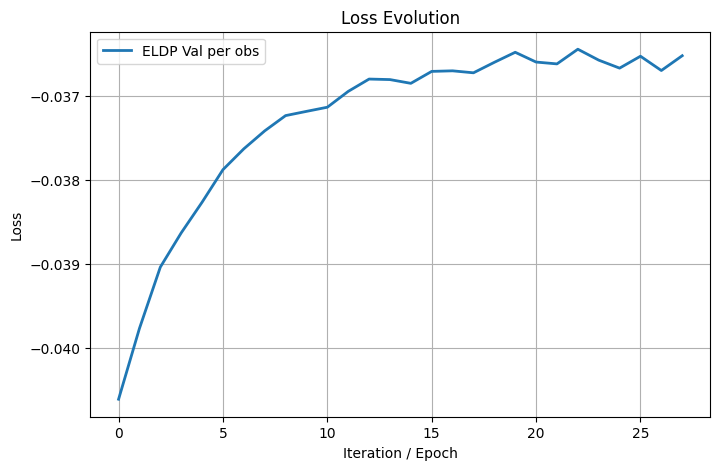

In [11]:
elbo= output['loss_history']
#loss_history = output['ll_history']
val_loss = output['val_history']



# Plot            
plt.figure(figsize=(8, 5))
plt.plot(val_loss, label="ELDP Val per obs", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [12]:
log_likelihood_train_bgtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_bgtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_bgtm = model.log_likelihood(simulated_data_test)


log_likelihood_train_gtm = model_freq.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model_freq.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model_freq.log_likelihood(simulated_data_test)

In [13]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = (mvn_model.log_prob(simulated_data_train)).to(device)
log_likelihood_validate_gaussian = (mvn_model.log_prob(simulated_data_validate)).to(device)
log_likelihood_test_gaussian = (mvn_model.log_prob(simulated_data_test)).to(device)


In [14]:
print("KLD BGTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_bgtm).item(),4) )
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )
print("")
print("KLD BGTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_bgtm).item(),4) )
print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD BGTM      Train Data:  0.0321
KLD GTM      Train Data:  0.0239
KLD Gaussian Train Data:  0.1318
KLD Copula   Train Data:  -0.0006

KLD BGTM      Test  Data:  0.0319
KLD GTM      Test  Data:  0.0222
KLD Gaussian Test  Data:  0.1083
KLD Copula   Test  Data:  0.0009


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [15]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)
model_freq.approximate_transformation_inverse()
synthetic_samples_freq = model_freq.sample(10000)

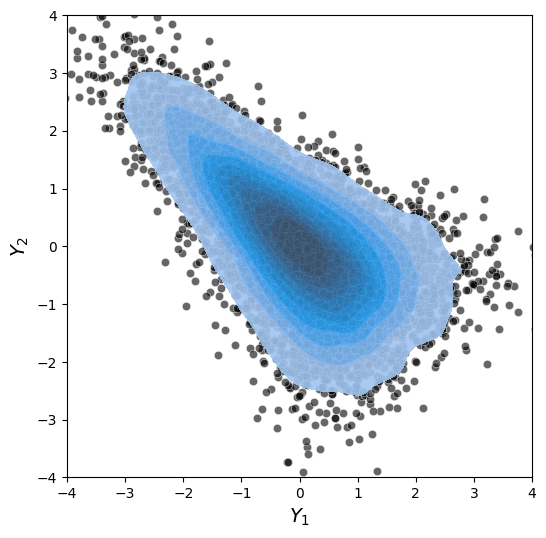

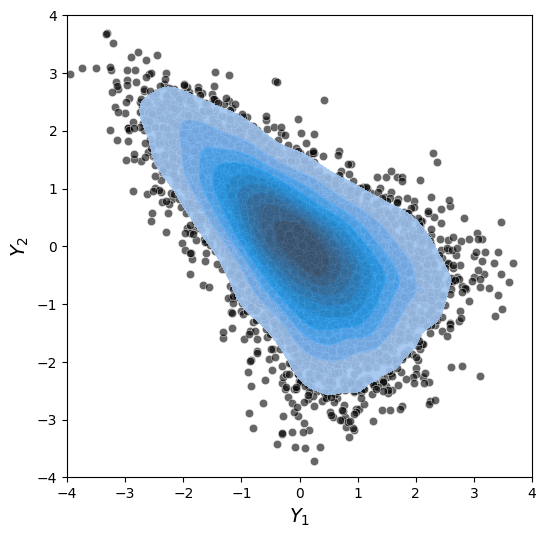

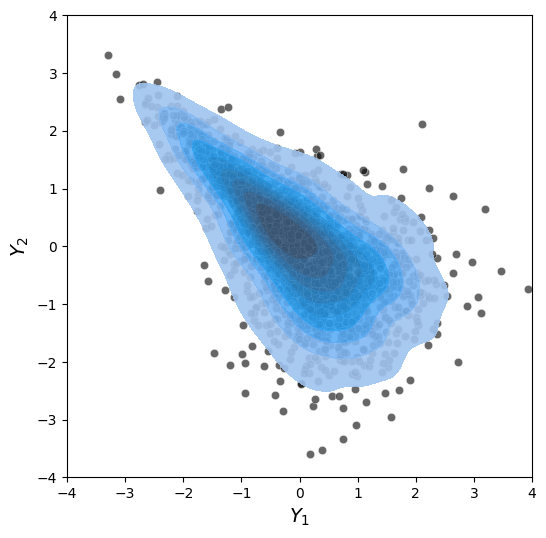

In [16]:
model.plot_densities(synthetic_samples.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model_freq.plot_densities(synthetic_samples_freq.cpu(), x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train.cpu(), x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [17]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

In [18]:
model.plot_conditional_dependence_structure(data=synthetic_samples.detach().cpu())

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

In [23]:
model.plot_splines(layer_type="transformation")

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=float, device=cuda:0, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

: 

: 

: 

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


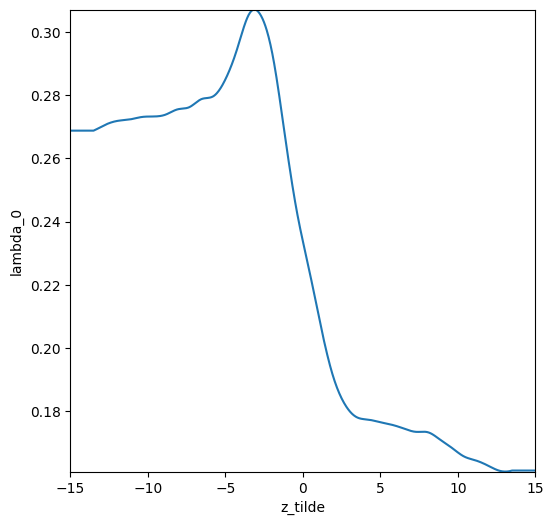

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


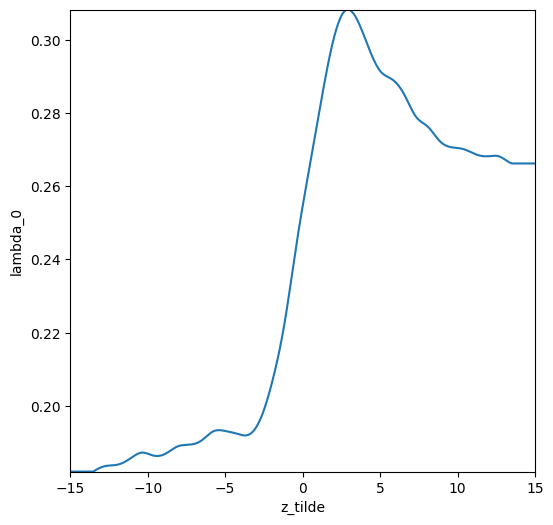

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/mnt/vast-standard/home/f.capunaycaceres/u22491/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


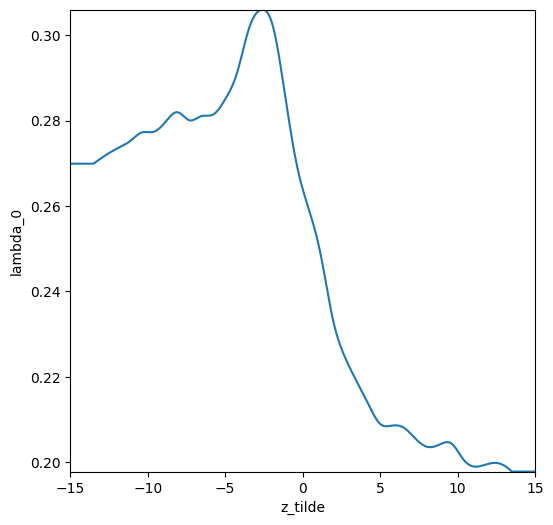

: 

: 

: 

In [ ]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)